# Penyeimbangan dataset (SMOTE, ADASYN)

# Download data lalu simpan di MYSQL

Gambar di bawah menampilkan repository yang memuat data mengenai protein localization sites. Pada halaman tersebut tersedia ringkasan informasi, seperti karakteristik dataset (multivariate), bidang kajian (biologi), tipe tugas (klasifikasi), jumlah instance (336 baris data), jumlah fitur (7 atribut), serta keterangan bahwa tidak terdapat nilai yang hilang. Untuk memperoleh dataset ini, pengguna cukup menekan tombol DOWNLOAD (5.5 KB) di sisi kanan halaman. File akan diunduh dalam format teks atau CSV, sehingga bisa langsung dimanfaatkan untuk keperluan analisis atau pemodelan machine learning.

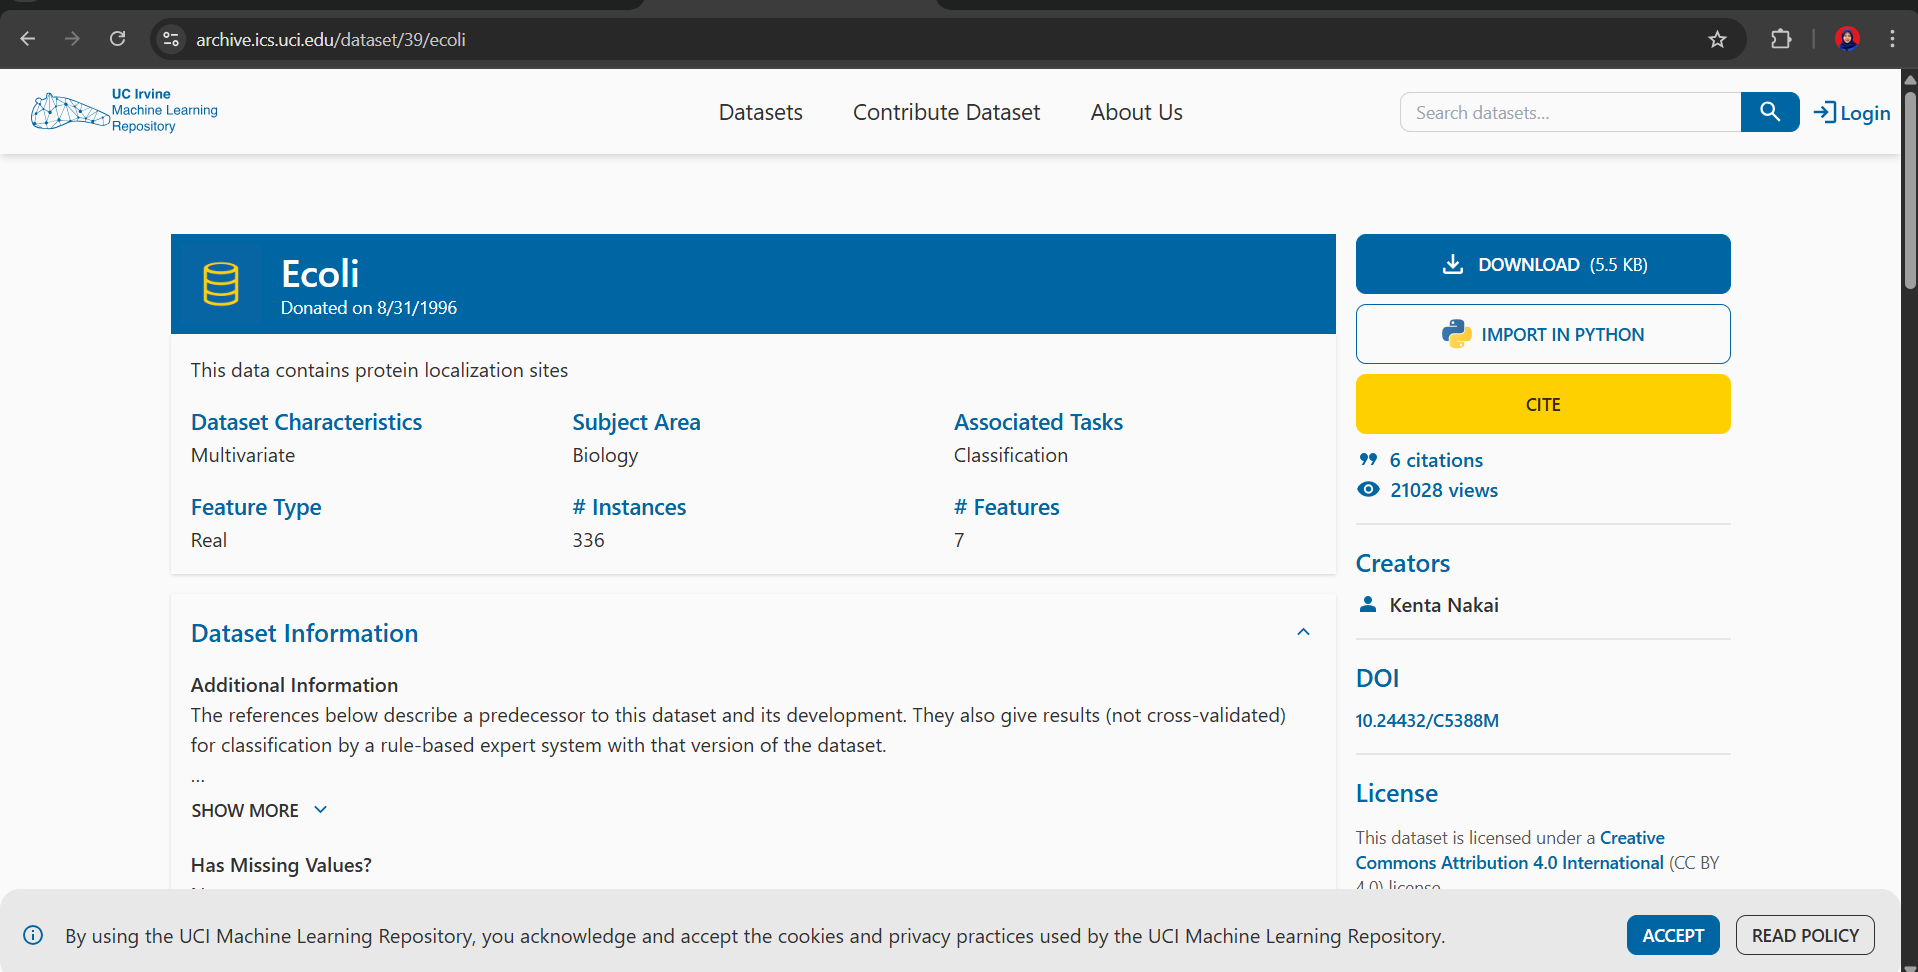

Gambar berikut menunjukkan proses impor dataset Ecoli dalam format .sql ke dalam MySQL menggunakan phpMyAdmin. Setelah file SQL diunduh dari UCI Repository atau hasil ekspor sebelumnya, langkah selanjutnya adalah mengimpornya agar tersimpan dan dapat dikelola di database MySQL. Prosedurnya adalah sebagai berikut:

Buka phpMyAdmin, kemudian pilih database yang akan digunakan (misalnya ecoli_dataset).

Klik menu Impor.

Pada bagian Berkas untuk impor, tekan Choose File, lalu pilih file ecoli_dataset.sql yang sudah diunduh.

Pastikan Set karakter berkas diatur ke utf-8 agar skrip SQL dapat dibaca dengan benar.

Format akan otomatis terdeteksi sebagai SQL, jadi tidak perlu memilih CSV.

Gulir ke bawah dan klik tombol Go untuk memulai impor.

Setelah proses selesai, MySQL akan menjalankan perintah-perintah yang terdapat pada file SQL tersebut dan membuat tabel beserta datanya sesuai struktur yang ada. Dengan cara ini, dataset dari UCI dapat langsung digunakan untuk query SQL, analisis, maupun integrasi ke aplikasi Anda.

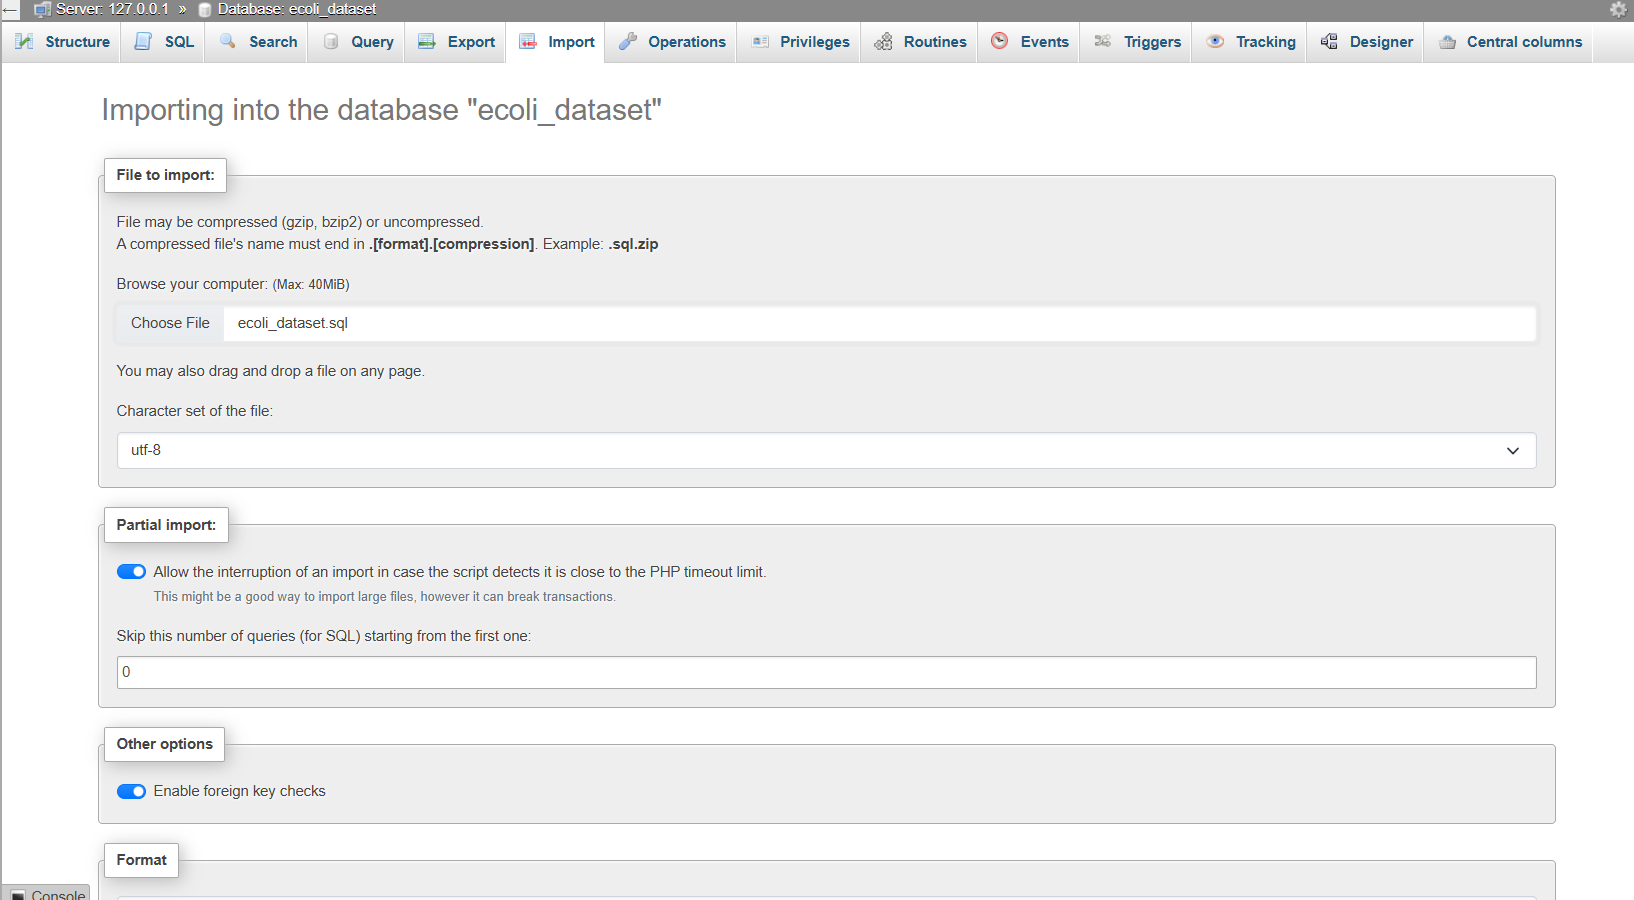

# Installing library

In [ ]:
pip install mysql-connector-python imbalanced-learn scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 52.4 MB/s eta 0:00:00


# Melakukan koneksi dan inisialisasi pada dataset awal

Kode Python berikut digunakan untuk mengunduh dataset Ecoli dari UCI Machine Learning Repository dan menyimpannya ke dalam objek DataFrame dengan pustaka pandas. Pada bagian awal, seluruh library yang diperlukan diimpor, antara lain pandas, numpy, matplotlib, seaborn, serta modul dari scikit-learn (StandardScaler, PCA). Selain itu, disertakan pula ADASYN dari imbalanced-learn untuk menangani ketidakseimbangan data, serta sqlalchemy yang berfungsi sebagai konektor ke basis data MySQL. Beberapa variabel konfigurasi, seperti MYSQL_USER, MYSQL_PASS, MYSQL_HOST, MYSQL_PORT, dan MYSQL_DB, sudah didefinisikan agar memudahkan proses penyimpanan data ke MySQL.

Selanjutnya, kode menentukan URL file dataset (ecoli.data) dan mendefinisikan daftar nama kolom sesuai dokumentasi UCI, mencakup atribut mcg, gvh, lip, chg, aac, alm1, alm2, serta class sebagai label. Dataset kemudian dibaca menggunakan pd.read_csv() dengan parameter sep=r"\s+" karena data dipisahkan oleh spasi atau tab. Hasil pembacaan disimpan dalam DataFrame bernama df, kemudian ditampilkan dimensi datanya melalui df.shape dan lima baris awal dengan df.head(). Langkah ini merupakan tahap verifikasi awal untuk memastikan dataset berhasil diunduh dan terbaca dengan benar sebelum melanjutkan ke analisis berikutnya, seperti penerapan PCA, visualisasi, maupun penyeimbangan data menggunakan ADASYN.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from sqlalchemy import create_engine


MYSQL_USER = "root"
MYSQL_PASS = ""
MYSQL_HOST = "127.0.0.1"
MYSQL_PORT = 3306
MYSQL_DB   = "ecoli_dataset"
TABLE_NAME = "ecoli_dataset"

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ecoli/ecoli.data"

col_names = ["seq_name", "mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2", "class"]

df = pd.read_csv(url, header=None, sep=r"\s+", names=col_names)
print("Shape:", df.shape)
print(df.head())


Shape: (336, 9)
     seq_name   mcg   gvh   lip  chg   aac  alm1  alm2 class
0   AAT_ECOLI  0.49  0.29  0.48  0.5  0.56  0.24  0.35    cp
1  ACEA_ECOLI  0.07  0.40  0.48  0.5  0.54  0.35  0.44    cp
2  ACEK_ECOLI  0.56  0.40  0.48  0.5  0.49  0.37  0.46    cp
3  ACKA_ECOLI  0.59  0.49  0.48  0.5  0.52  0.45  0.36    cp
4   ADI_ECOLI  0.23  0.32  0.48  0.5  0.55  0.25  0.35    cp


# Visualisasi Data dengan PCA

Kode ini dibuat untuk melakukan eksplorasi sekaligus visualisasi dataset Ecoli melalui dua pendekatan utama. Pertama, digunakan pairplot dari pustaka seaborn untuk memperlihatkan hubungan antar sejumlah fitur numerik penting (mcg, gvh, lip, chg, aac, alm1, alm2) dengan label kelas sebagai hue. Dalam pairplot, distribusi masing-masing fitur ditampilkan pada sumbu diagonal, sedangkan hubungan serta korelasi antar fitur divisualisasikan melalui scatter plot di luar diagonal. Representasi ini memberikan pandangan awal mengenai pola data, keterkaitan variabel, dan penyebaran setiap kelas Ecoli di ruang fitur asli sebelum dilakukan reduksi dimensi.

Langkah berikutnya adalah menormalkan data menggunakan StandardScaler agar seluruh fitur memiliki skala yang seimbang. Setelah itu, diterapkan Principal Component Analysis (PCA) untuk menyederhanakan dimensi data menjadi dua komponen utama (PC1 dan PC2). Hasil transformasi PCA dimasukkan ke dalam DataFrame baru bernama df_plot, kemudian divisualisasikan dengan scatter plot. Tiap titik mewakili satu observasi, sedangkan warnanya merepresentasikan kelas masing-masing. Grafik PCA ini membantu memahami pola dan memisahkan kelas-kelas dalam ruang dua dimensi, sekaligus memudahkan perbandingan dengan penyebaran asli pada pairplot, terutama untuk melihat adanya area tumpang tindih atau klaster dari setiap kelas.

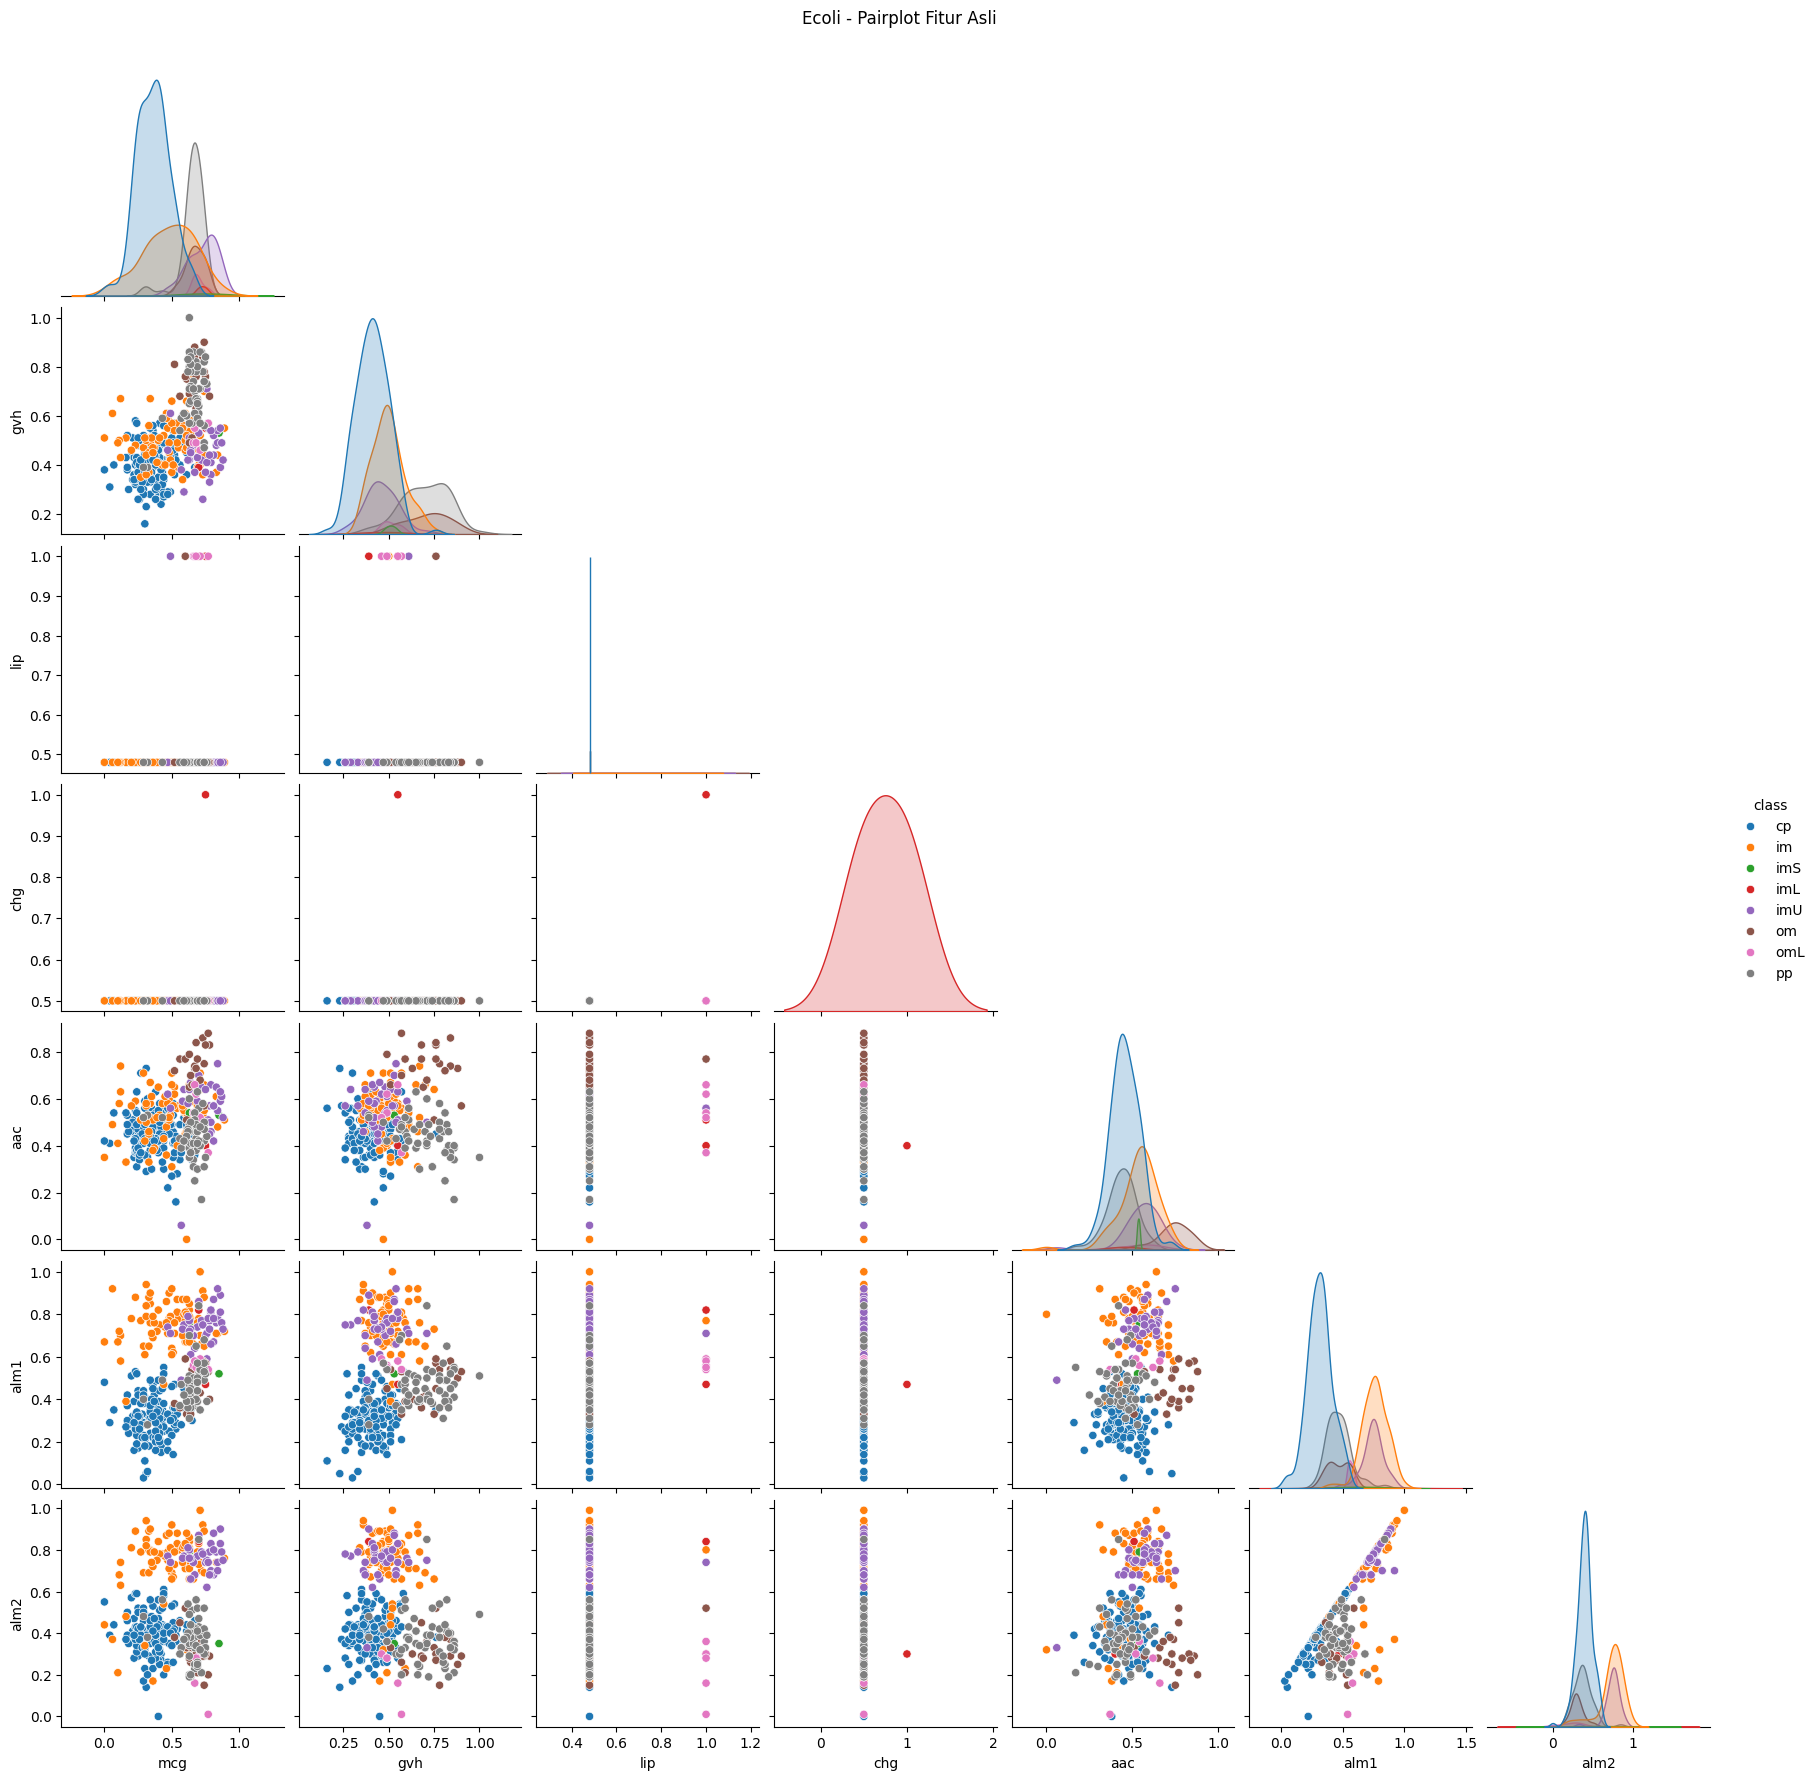

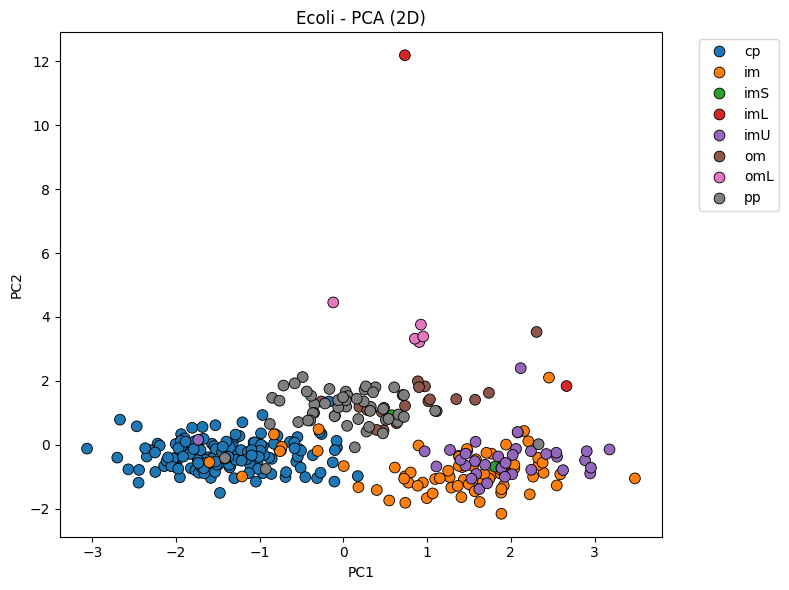

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]
X = df[features]
y = df["class"]

df_pair = X.copy()
df_pair["class"] = y
sns.pairplot(df_pair, hue="class", corner=True, diag_kind="kde", palette="tab10")
plt.suptitle("Ecoli - Pairplot Fitur Asli", y=1.02)
plt.show()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_plot = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "class": y
})

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="class", palette="tab10", s=60, edgecolor="k")
plt.title("Ecoli - PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()


# Penyeimbangan Data

## SMOTE

Potongan kode ini digunakan untuk melakukan penyeimbangan distribusi kelas pada dataset Ecoli menggunakan metode SMOTE (Synthetic Minority Oversampling Technique). Pertama, ditentukan fitur-fitur numerik utama sebagai X dan label kelas sebagai y. SMOTE kemudian dijalankan dengan parameter k_neighbors=1 untuk mencegah terjadinya kesalahan pada kelas minoritas yang memiliki jumlah sampel sangat sedikit. Melalui fungsi fit_resample, dihasilkan X_res dan y_res, yaitu versi dataset yang sudah seimbang sehingga setiap kelas memiliki jumlah data yang relatif serupa. Selain itu, kode juga menampilkan jumlah sampel per kelas sebelum dan sesudah proses penyeimbangan menggunakan pd.Series.value_counts() agar efek oversampling mudah diverifikasi.

Tahap selanjutnya adalah mengidentifikasi sampel sintetis yang dihasilkan SMOTE dengan membandingkan setiap baris pada hasil resampling (X_res) dengan data asli (X). Untuk keperluan ini, fungsi rows_to_keys digunakan untuk mengubah setiap baris menjadi string unik berdasarkan nilai fitur yang telah dibulatkan, sehingga dapat dibandingkan secara akurat. Variabel is_synthetic berupa nilai boolean yang menandai apakah suatu baris merupakan data hasil generasi SMOTE (True) atau berasal dari dataset asli (False). Informasi ini membantu mengetahui jumlah sampel tambahan yang dibuat, yang bermanfaat untuk keperluan visualisasi maupun analisis lanjutan, misalnya saat ingin menampilkan scatter plot PCA dengan penanda khusus bagi data sintetis.

In [ ]:

from imblearn.over_sampling import SMOTE

features = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]
X = df[features].values
y = df["class"].values

smote = SMOTE(random_state=42, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

print("Before balancing:", pd.Series(y).value_counts().to_dict())
print("After  balancing:", pd.Series(y_res).value_counts().to_dict())

# tandai synthetic samples
def rows_to_keys(arr):
    arr_rounded = np.round(arr.astype(float), 8)
    keys = ["|".join(map(str, row)) for row in arr_rounded]
    return np.array(keys)

orig_keys = rows_to_keys(X)
res_keys  = rows_to_keys(X_res)
orig_key_set = set(orig_keys.tolist())
is_synthetic = np.array([k not in orig_key_set for k in res_keys])

print("Jumlah sampel resampled:", len(X_res))
print("Jumlah synthetic terdeteksi:", is_synthetic.sum())


Before balancing: {'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20, 'omL': 5, 'imL': 2, 'imS': 2}
After  balancing: {'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}
Jumlah sampel resampled: 1144
Jumlah synthetic terdeteksi: 808


## ADASYN
Potongan kode ini memperlihatkan pendekatan kombinasi untuk menyeimbangkan dataset Ecoli yang memiliki kelas dengan jumlah sampel sangat sedikit. Langkah pertama menggunakan SMOTE dengan parameter k_neighbors=1 untuk memperbanyak data pada kelas ultra-minoritas, sehingga setiap kelas memiliki jumlah sampel minimum yang memadai. Hasil resampling disimpan ke dalam X_sm dan y_sm, lalu distribusi jumlah data per kelas ditampilkan menggunakan pd.Series.value_counts() agar efek penambahan data sintetis dari SMOTE dapat diamati.

Sesudah kelas dengan jumlah paling sedikit cukup terwakili, proses dilanjutkan dengan menerapkan ADASYN pada dataset hasil SMOTE. Sama seperti sebelumnya, ADASYN juga menggunakan n_neighbors=1 agar dapat berjalan dengan baik pada kelas minoritas yang kecil. Teknik ini menghasilkan data sintetis secara lebih adaptif dengan mempertimbangkan distribusi kelas mayoritas di sekitar data minoritas. Output akhirnya tersimpan pada X_ada dan y_ada, kemudian jumlah sampel tiap kelas kembali ditampilkan. Melalui kombinasi metode ini, dataset menjadi lebih seimbang dan siap digunakan untuk analisis atau visualisasi berikutnya, seperti PCA untuk memeriksa sebaran data asli maupun data sintetis.


In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

# 1. SMOTE dulu untuk mengatasi kelas ultra-minoritas
smote = SMOTE(random_state=42, k_neighbors=1)
X_sm, y_sm = smote.fit_resample(X_scaled, y)

print("Setelah SMOTE:", pd.Series(y_sm).value_counts().to_dict())

# 2. Baru jalankan ADASYN di hasil SMOTE
adasyn = ADASYN(random_state=42, n_neighbors=1)
X_ada, y_ada = adasyn.fit_resample(X_sm, y_sm)

print("Setelah SMOTE+ADASYN:", pd.Series(y_ada).value_counts().to_dict())


Setelah SMOTE: {'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}
Setelah SMOTE+ADASYN: {'cp': 143, 'im': 143, 'imS': 143, 'imL': 143, 'imU': 143, 'om': 143, 'omL': 143, 'pp': 143}


#Visualisasi data akhir

Kode ini dimanfaatkan untuk menampilkan visualisasi dataset Ecoli yang telah melalui proses penyeimbangan dalam bentuk PCA dua dimensi. Langkah pertama adalah menormalisasi data hasil resampling (X_res) dengan StandardScaler agar seluruh fitur berada pada skala yang seragam. Setelah itu, dilakukan Principal Component Analysis (PCA) untuk mereduksi dimensi menjadi dua komponen utama (PC1 dan PC2), sehingga distribusi sampel dapat ditampilkan pada ruang dua dimensi. Hasil transformasi disimpan di dalam df_res_plot, yang juga memuat penanda is_synthetic untuk membedakan sampel asli dengan data sintetis yang dihasilkan oleh metode oversampling, seperti ADASYN.

Berikutnya, dibuat scatter plot menggunakan seaborn, di mana titik-titik berwarna merepresentasikan sampel asli sesuai kelas, sedangkan data sintetis digambarkan dengan marker x berwarna hitam. Visualisasi ini membantu mengenali pola serta sebaran antara data asli dan sampel tambahan dari ADASYN. Grafik dilengkapi dengan judul, label sumbu, dan legenda agar mudah dipahami, dan dapat diekspor sebagai file gambar dengan plt.savefig untuk keperluan dokumentasi maupun laporan.


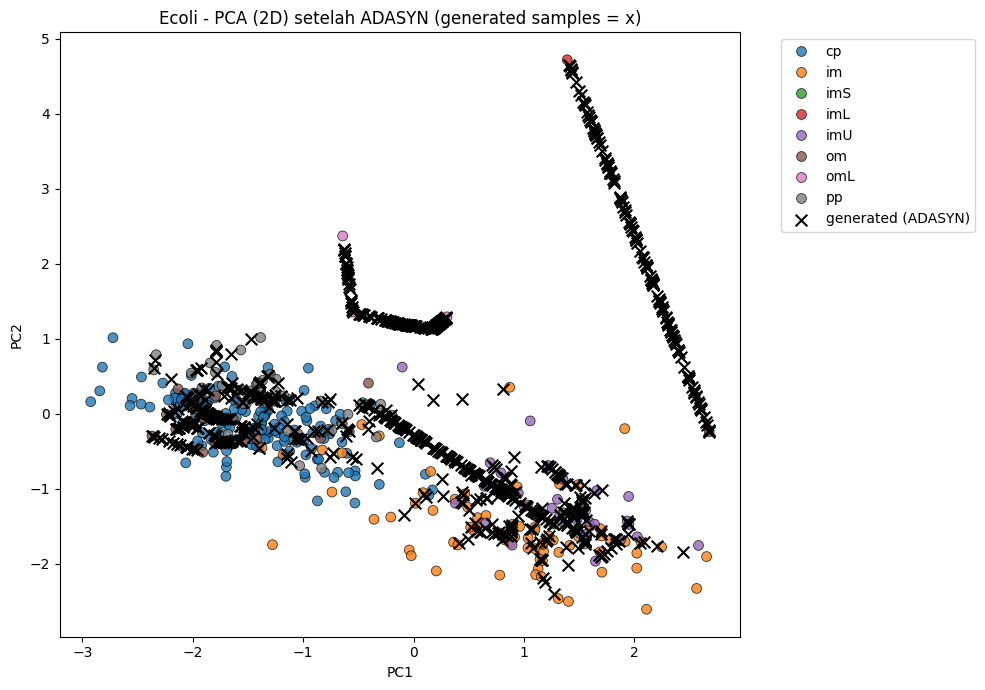

<Figure size 640x480 with 0 Axes>

In [ ]:

scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)

pca_res = PCA(n_components=2, random_state=42)
X_res_pca = pca_res.fit_transform(X_res_scaled)

df_res_plot = pd.DataFrame({
    "PC1": X_res_pca[:,0],
    "PC2": X_res_pca[:,1],
    "class": y_res,
    "is_synthetic": is_synthetic
})

plt.figure(figsize=(10,7))
# plot data asli
sns.scatterplot(data=df_res_plot[df_res_plot["is_synthetic"]==False],
                x="PC1", y="PC2", hue="class", palette="tab10",
                s=50, edgecolor="k", alpha=0.8)

# plot data synthetic
synthetic = df_res_plot[df_res_plot["is_synthetic"]==True]
plt.scatter(synthetic["PC1"], synthetic["PC2"],
            marker="x", s=70, c="black", label="generated (ADASYN)")

plt.title("Ecoli - PCA (2D) setelah ADASYN (generated samples = x)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

# Optional: save plots
plt.savefig("ecoli_pca_original.png", dpi=200)
plt.savefig("ecoli_pca_adasyn.png", dpi=200)


Kode berikut digunakan untuk memvisualisasikan dampak penyeimbangan kelas pada dataset Ecoli melalui tiga tahap: data awal, setelah SMOTE, serta setelah kombinasi SMOTE + ADASYN. Langkah pertama adalah menormalkan fitur menggunakan StandardScaler, kemudian mereduksi dimensi dengan PCA menjadi dua komponen utama (PC1 dan PC2). Sebuah fungsi bernama get_synthetic_mask dibuat untuk mengidentifikasi sampel sintetis yang dihasilkan metode oversampling dengan cara membandingkan data hasil resampling terhadap dataset asli. Setiap tahap disimpan dalam DataFrame terpisah, dengan kolom is_synthetic yang menunjukkan apakah suatu sampel merupakan hasil generasi.

Visualisasi ditampilkan dalam satu figure yang berisi tiga subplot. Plot pertama memperlihatkan distribusi data asli dengan pewarnaan berdasarkan kelas. Plot kedua menampilkan hasil SMOTE, di mana data asli diberi warna sesuai kelas, sedangkan sampel sintetis ditandai dengan simbol x berwarna hitam. Plot ketiga menunjukkan hasil kombinasi SMOTE + ADASYN dengan format serupa. Melalui visualisasi ini, kita dapat dengan jelas mengamati bagaimana data minoritas ditambahkan, distribusi kelas menjadi lebih merata, serta pengaruh metode oversampling terhadap struktur data setelah reduksi PCA.

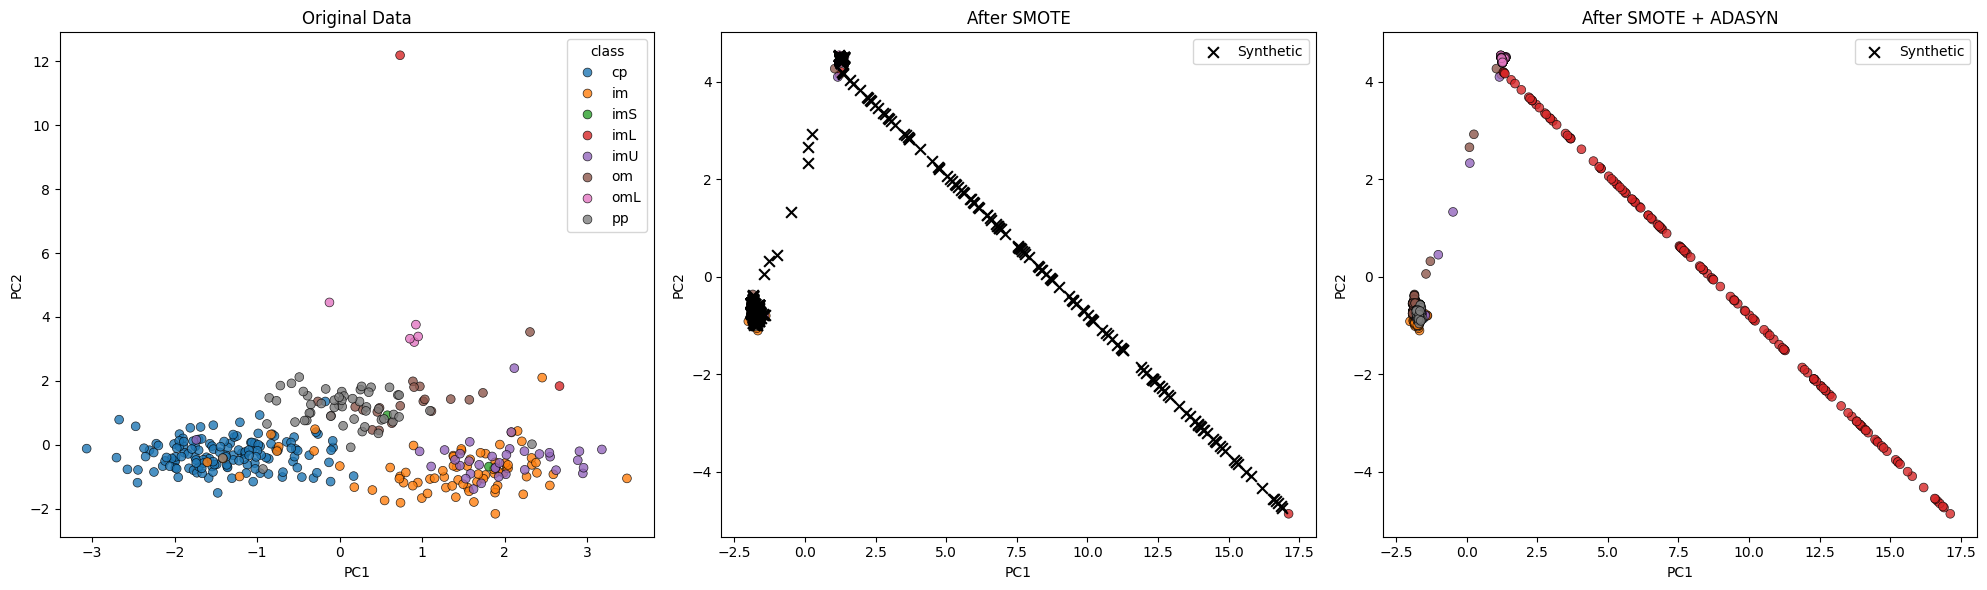

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN
import numpy as np
import pandas as pd

features = ["mcg", "gvh", "lip", "chg", "aac", "alm1", "alm2"]
X = df[features].values
y = df["class"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def get_synthetic_mask(X_orig, X_res):
    orig_keys = set(map(tuple, np.round(X_orig, 8)))
    res_keys  = list(map(tuple, np.round(X_res, 8)))
    return np.array([k not in orig_keys for k in res_keys])

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_orig = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "class": y,
    "is_synthetic": False
})

smote = SMOTE(random_state=42, k_neighbors=1)
X_sm, y_sm = smote.fit_resample(X_scaled, y)

mask_smote = get_synthetic_mask(X_scaled, X_sm)

X_sm_pca = pca.fit_transform(X_sm)
df_sm = pd.DataFrame({
    "PC1": X_sm_pca[:,0],
    "PC2": X_sm_pca[:,1],
    "class": y_sm,
    "is_synthetic": mask_smote
})

adasyn = ADASYN(random_state=42, n_neighbors=1)
X_ada, y_ada = adasyn.fit_resample(X_sm, y_sm)

mask_ada = get_synthetic_mask(X_sm, X_ada)

X_ada_pca = pca.fit_transform(X_ada)
df_ada = pd.DataFrame({
    "PC1": X_ada_pca[:,0],
    "PC2": X_ada_pca[:,1],
    "class": y_ada,
    "is_synthetic": mask_ada
})

fig, axes = plt.subplots(1, 3, figsize=(20,6))

# Original
sns.scatterplot(data=df_orig, x="PC1", y="PC2", hue="class",
                s=40, alpha=0.8, edgecolor="k", ax=axes[0])
axes[0].set_title("Original Data")

# SMOTE
sns.scatterplot(data=df_sm[df_sm["is_synthetic"]==False],
                x="PC1", y="PC2", hue="class",
                s=40, alpha=0.8, edgecolor="k", ax=axes[1], legend=False)
synthetic = df_sm[df_sm["is_synthetic"]==True]
axes[1].scatter(synthetic["PC1"], synthetic["PC2"],
                c="black", marker="x", s=60, label="Synthetic")
axes[1].set_title("After SMOTE")
axes[1].legend()

# SMOTE + ADASYN
sns.scatterplot(data=df_ada[df_ada["is_synthetic"]==False],
                x="PC1", y="PC2", hue="class",
                s=40, alpha=0.8, edgecolor="k", ax=axes[2], legend=False)
synthetic = df_ada[df_ada["is_synthetic"]==True]
axes[2].scatter(synthetic["PC1"], synthetic["PC2"],
                c="black", marker="x", s=60, label="Synthetic")
axes[2].set_title("After SMOTE + ADASYN")
axes[2].legend()

plt.tight_layout()
plt.show()
